In [1]:
##第二次 泰坦尼克之灾 解答
##参考https://www.jianshu.com/p/e79a8c41cb1a

In [2]:
#导入包
#matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
#导入数据
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
PassengerId=test['PassengerId']
all_data=pd.concat([train,test],ignore_index=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

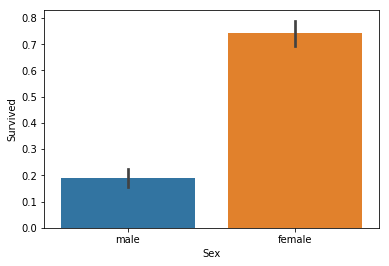

In [5]:
sns.barplot(x="Sex", y="Survived", data=train)
plt.show()

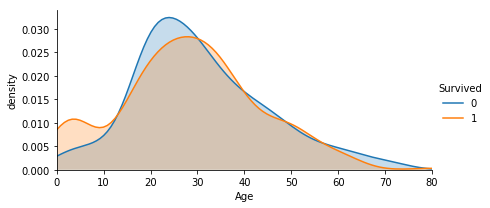

In [6]:
facet=sns.FacetGrid(train,hue='Survived',aspect=2)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0,train['Age'].max()))
facet.add_legend()
plt.xlabel('Age')
plt.ylabel('density')
plt.show()

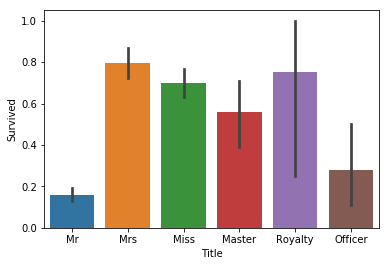

In [7]:
#特征工程 加入头衔
all_data['Title']=all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict={}
Title_Dict.update(dict.fromkeys(['Capt','Col','Major','Dr','Rev'],'Officer'))
Title_Dict.update(dict.fromkeys(['Don','Sir','the Countess','Dona','Lady'],'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme','Ms','Mrs'],'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle','Miss'],'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'],'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'],'Master'))

all_data['Title']=all_data['Title'].map(Title_Dict)
sns.barplot(x='Title',y='Survived',data=all_data)
plt.show()

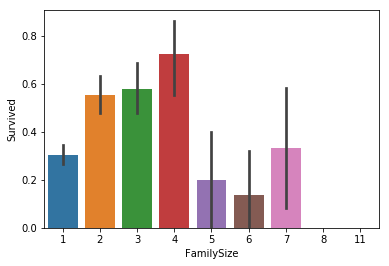

In [8]:
#特征工程 加入家庭成员数
all_data['FamilySize']=all_data['SibSp']+all_data['Parch']+1
sns.barplot(x='FamilySize',y='Survived',data=all_data)
plt.show()

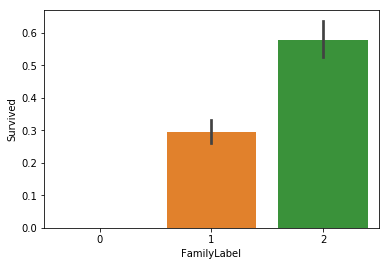

In [9]:
#按FamilySize分为三类
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0

all_data['FamilyLabel']=all_data['FamilySize'].apply(Fam_label)
sns.barplot(x='FamilyLabel',y='Survived',data=all_data)
plt.show()

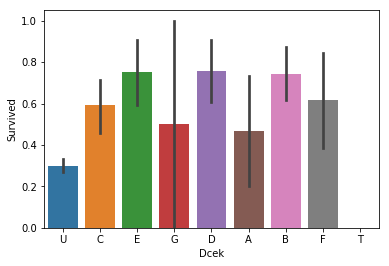

In [10]:
#特征工程 Cabin
all_data['Cabin']=all_data['Cabin'].fillna('Unknown')
all_data['Dcek']=all_data['Cabin'].str.get(0)
sns.barplot(x='Dcek',y='Survived',data=all_data)
plt.show()

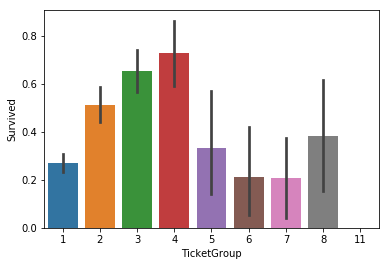

In [11]:
#特征工程 新增TicketGroup 团体票
Ticket_Count=dict(all_data['Ticket'].value_counts())
all_data['TicketGroup']=all_data['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x='TicketGroup',y='Survived',data=all_data)
plt.show()


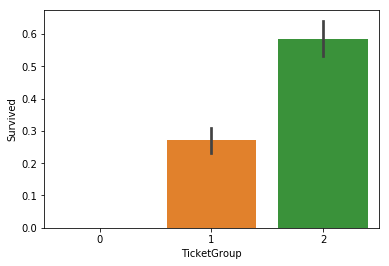

In [12]:
#按生存率将TicketGroup分为三类
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data)
plt.show()

In [13]:
#填补缺失的Age数据
from sklearn.ensemble import RandomForestRegressor
age_df=all_data[['Age','Pclass','Sex','Title']]
age_df=pd.get_dummies(age_df)
known_age=age_df[age_df.Age.notnull()].as_matrix()
unknown_age=age_df[age_df.Age.isnull()].as_matrix()
y=known_age[:,0]
X=known_age[:,1:]
rfr=RandomForestRegressor(random_state=0,n_estimators=100,n_jobs=-1)
rfr.fit(X,y)
predictedAges=rfr.predict(unknown_age[:,1:])
all_data.loc[(all_data.Age.isnull()),'Age']=predictedAges

In [14]:
#查看缺失的Embarked值
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Dcek,TicketGroup
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,1,1,B,2
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,1,1,B,2


In [15]:
#观察港口舱等级的票价的中位数
all_data.groupby(by=['Pclass','Embarked']).Fare.median()

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [16]:
#Embarked缺失量为2，缺失Embarked信息的乘客的Pclass均为1，且Fare均为80，
#因为Embarked为C且Pclass为1的乘客的Fare中位数为80，所以缺失值填充为C

all_data['Embarked']=all_data['Embarked'].fillna('C')

In [17]:
#查看缺失的Fare值
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Dcek,TicketGroup
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,1,1,U,1


In [18]:
#缺失Fare信息的乘客的Embarked为S，Pclass为3，
#所以用Embarked为S，Pclass为3的乘客的Fare中位数填充

fare=all_data[(all_data['Embarked']=='S')&(all_data['Pclass']==3)].Fare.median()
all_data['Fare']=all_data['Fare'].fillna(fare)

In [19]:
#按姓氏分组
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count=dict(all_data['Surname'].value_counts())
all_data['FamilyGroup']=all_data['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group=all_data.loc[(all_data['FamilyGroup']>=2)&((all_data['Age']<=12)|(all_data['Sex']=='female'))]
Male_Adult_Group=all_data.loc[(all_data['FamilyGroup']>=2)&(all_data['Age']>12)&(all_data['Sex']=='male')]


In [20]:
#同组的女性和儿童要么全部幸存，要么全部遇难
Female_Child=pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns=['GroupCount']
Female_Child

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


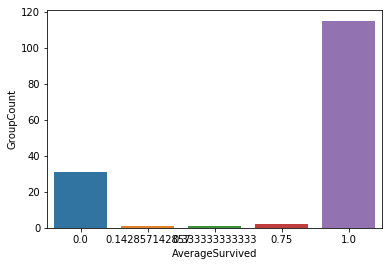

In [21]:
sns.barplot(x=Female_Child.index,y=Female_Child['GroupCount']).set_xlabel('AverageSurvived')
plt.show()

In [22]:
Male_Adult=pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


In [23]:
#将女性和儿童组中幸存率为0的组设置为遇难组，
#把成年男性组中存活率为1的设置为幸存组
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)
Male_Adult_Group=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_Group[Male_Adult_Group.apply(lambda x:x==1)].index)
print(Survived_List)

{'Ford', 'Arnold-Franchi', 'Ilmakangas', 'Danbom', 'Boulos', 'Strom', 'Lefebre', 'Caram', 'Vander Planke', 'Turpin', 'Oreskovic', 'Barbara', 'Olsson', 'Sage', 'Lobb', 'Jussila', 'Zabour', 'Robins', 'Rosblom', 'Canavan', 'Rice', 'Bourke', 'Johnston', 'Skoog', 'Cacic', 'Lahtinen', 'Palsson', 'Van Impe', 'Panula', 'Attalah', 'Goodwin'}
{'Frauenthal', 'Dick', 'Cardeza', 'Goldenberg', 'Greenfield', 'Beckwith', 'McCoy', 'Nakid', 'Harder', 'Kimball', 'Taylor', 'Duff Gordon', 'Jussila', 'Jonsson', 'Chambers', 'Bishop', 'Frolicher-Stehli', 'Bradley', 'Daly', 'Beane'}


In [24]:
#对遇难组和幸存组这些反常组进行惩罚修改
train=all_data.loc[all_data['Survived'].notnull()]
test=all_data.loc[all_data['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex']='male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age']=60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title']='Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex']='female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age']=5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title']='Miss'


In [26]:
#选取特征 转换为数值变量

all_data=pd.concat([train,test])
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Dcek','TicketGroup']]
all_data=pd.get_dummies(all_data)
train=all_data[all_data['Survived'].notnull()]
test=all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)
X=train.as_matrix()[:,1:]
y=train.as_matrix()[:,0]


In [28]:
#建模 寻求最优参数
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

pipe=Pipeline([('select',SelectKBest(k=20)), 
               ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20,50,2)), 
              'classify__max_depth':list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)


{'classify__max_depth': 6, 'classify__n_estimators': 42} 0.88109635084


In [30]:
#训练模型
from sklearn.pipeline import make_pipeline
select=SelectKBest(k=20)
clf=RandomForestClassifier(random_state=10,warm_start=True,
                          n_estimators=26,
                          max_depth=6,
                          max_features='sqrt')
pipeline=make_pipeline(select,clf)
pipeline.fit(X,y)


Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x000002017AB11730>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decreas...estimators=26, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=True))])

In [31]:
#交叉验证
from sklearn import cross_validation, metrics
cv_score=cross_validation.cross_val_score(pipeline,X,y,cv=10)
print("CV score : Mean - %.7g | Std - %.7g" % (np.mean(cv_score),np.std(cv_score)))


D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


CV score : Mean - 0.8451402 | Std - 0.03276752


In [32]:
#预测
predictions=pipeline.predict(test)
submission=pd.DataFrame({'PassengerId':PassengerId,'Survived':predictions.astype(np.int32)})
submission.to_csv('submission.csv',index=False)